In [57]:
using Downloads, Unicode, Statistics, StatsBase, Plots, Random, Flux, Zygote, TSne, LinearAlgebra

In [71]:
alice_file = Downloads.download(alice_url) 
raw_text = read(alice_file, String)
length(raw_text)

167673

In [18]:
function tokenize(s::String)
    s = lowercase(s)
    s = replace(s, r"[^\p{L}\s]" => "")   # keep letters and whitespace
    filter(!isempty, split(s))            # split on spaces, drop empties
end

tokens = tokenize(raw_text)
println("Corpus size: $(length(tokens)) tokens")

Corpus size: 29463 tokens


In [75]:
vocab_size = 2000      # vocabulary cap (most frequent words)
counts = countmap(tokens)
vocab  = collect(keys(counts))
sort!(vocab, by = w -> -counts[w])
vocab  = vocab[1:vocab_size]

w2i = Dict(w => i for (i,w) in enumerate(vocab))   # word -> index
i2w = vocab    # index -> word (just a renaming of the vocabulary)

corpus = [w2i[w] for w in tokens if haskey(w2i, w)] # integerised corpus
println("Training on $(length(corpus)) in-vocab tokens")
println(i2w[1]) #prints "the" as the first token word using the index
println(w2i["the"]) #prints 1 as the first token index using the word
println(corpus[1:4])

Training on 28270 in-vocab tokens
the
1
[1, 46, 49, 313]


In [37]:
window = 2
pairs  = Tuple{Int,Int}[]

for (pos, center) in enumerate(corpus)
    for offset in -window:window
        offset == 0 && continue
        ctx_pos = pos + offset
        1 <= ctx_pos <= length(corpus) || continue
        push!(pairs, (center, corpus[ctx_pos]))
    end
end
println("Pairs: $(length(pairs))")
println(pairs[1:10])

Pairs: 113074
[(1, 46), (1, 49), (46, 1), (46, 49), (46, 313), (49, 1), (49, 46), (49, 313), (49, 5), (313, 46)]


In [76]:
dimension = 50  # embed dimension (directly plottable!)
E = randn(dimension, vocab_size) * 0.01 # input matrix (embedding)
W = randn(vocab_size, dimension) * 0.01 # output matrix
params = Flux.params(E, O)

function loss_pair(center::Int, token::Int)
    y_pred = Flux.softmax(W * E[:, center]) #vocab_size-vector
    return -log(y_pred[token]) #cross-entropy for one target
end

loss_pair (generic function with 1 method)

In [51]:
eta = 0.05 # step size
epochs = 10
loss_hist = Float64[]

rng = MersenneTwister(42) # repeatability

for epoch in 1:epochs
    shuffle!(rng, pairs) # shake it up
    epoch_loss = 0.0

    for (center, token) in pairs
        grad = Zygote.gradient(() -> loss_pair(center, token), params)
        # manual weight update
        for p in params
            p .-= eta * grad[p]
        end
        epoch_loss += loss_pair(center,token)
    end

    push!(loss_hist, epoch_loss/length(pairs))
    println("epoch $epoch  avg loss = $(round(loss_hist[end], digits = 4))")
end


epoch 1  avg loss = 6.0536
epoch 2  avg loss = 5.3722
epoch 3  avg loss = 5.1494
epoch 4  avg loss = 4.9608
epoch 5  avg loss = 4.793
epoch 6  avg loss = 4.6469
epoch 7  avg loss = 4.5205
epoch 8  avg loss = 4.4124
epoch 9  avg loss = 4.3209
epoch 10  avg loss = 4.2459


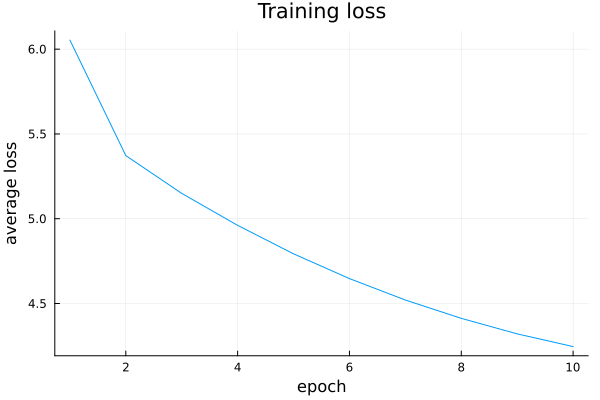

In [55]:
p = plot(loss_hist, xlabel="epoch", ylabel="average loss",
            title="Training loss", legend=false)

savefig(p,"loss.png")
display(p)

In [ ]:
embed_norm = E ./ sqrt.(sum(E .^ 2; dims = 1)) #columnwise normalization

50×2000 Matrix{Float64}:
 -0.0672916    0.0317106   0.272108   …   0.175892     0.253958
 -0.0675857    0.254348    0.037539       0.0541641    0.380977
 -0.0894239   -0.116444   -0.238969      -0.154595    -0.241961
  0.241405     0.11669    -0.137619       0.141975     0.0583684
 -0.0353048   -0.125248   -0.0982067     -0.128395    -0.0876493
  0.00335388   0.212907    0.244407   …   0.094873    -0.0420167
 -0.160055     0.291734    0.114828       0.132342     0.258478
 -0.073355     0.282115   -0.017285      -0.0329426    0.0410838
  0.0773406   -0.161154    0.0923286     -0.159733     0.0173126
 -0.0470764    0.115306   -0.0222184      0.0879259    0.0464251
  ⋮                                   ⋱               
  0.297505     0.0244847   0.0852186      0.130929    -0.145643
 -0.0557305    0.0383751  -0.0400149     -0.0837215   -0.135
 -0.0253682    0.078198    0.130692      -0.147032    -0.0259397
 -0.113375     0.0906299  -0.115613      -0.00825321   0.0551129
 -0.0604024   -0.13

In [80]:
ind_temp = w2i["cat"]
println(embed_norm[:,ind_temp][1:10])

[0.06956842056296993, 0.20641481185753066, 0.0019466199457948822, 0.16654404997007966, -0.036056986629078434, 0.032332004065396776, 0.34761353741585965, -0.15706733569028117, 0.13613879828325423, -0.08938170413908696]


In [59]:
function closest_words(word::String; k::Int = 5)
    idx = w2i[word]                          
    sims = vec(embed_norm' * embed_norm[:, idx])
    order = sortperm(sims; rev = true)        
    order = filter(!=(idx), order)  #drop the word itself
    return i2w[order[1:k]]
end

closest_words (generic function with 1 method)

In [62]:
println("nearest to  alice= ", closest_words("alice"))
println("nearest to    cat= ", closest_words("cat"))
println("nearest to    queen= ", closest_words("queen"))

nearest to  alice= SubString{String}["ada", "quarrelled", "purring", "rightly", "dreaming"]
nearest to    cat= SubString{String}["pigeon", "cutting", "idiot", "seeing", "hatter"]
nearest to    queen= SubString{String}["cook", "mostly", "goose", "king", "hatter"]


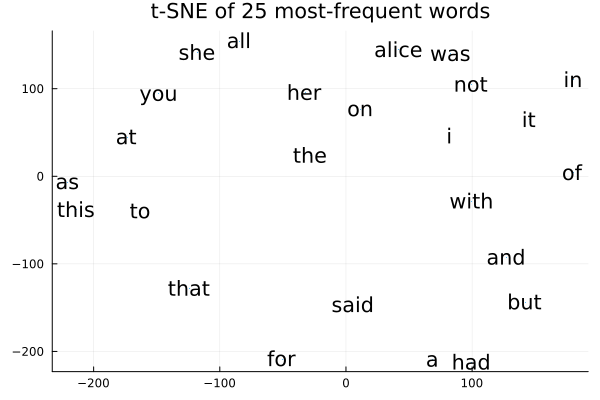

In [ ]:
topN  = 25
inds  = 1:topN
X     = embed_norm[:, inds]' # 20 x 50
Y     = tsne(X, 2, 50, 5)

p = scatter(Y[:,1], Y[:,2],
        text       = i2w[inds],
        markersize = 0,
        legend     = false,
        title      = "t-SNE of $topN most-frequent words")

savefig(p, "tsne.png")
display(p)
